# Bitcoin Historical Data


Bitcoin data at 1-min intervals from select exchanges, Jan 2012 to Jan 2018

## Context

Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by 
the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions
verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record 
keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous
transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that 
have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments 
soon followed public adoption of bitcoin and continue to grow.

Reference Material: 

* RNN and LSTM : http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* LSTM on time series using Keras : https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


## An unrolled recurrent neural network.


<img src='http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png'>

This chain-like nature reveals that recurrent neural networks are intimately related to sequences and lists. 
They’re the natural architecture of neural network to use for such data. In the last few years, there have been incredible success applying RNNs to a variety of problems: speech recognition, language modeling, translation, image captioning. 

## Long Short-Term Memory Network
The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using 
Backpropagation Through Time and overcomes the vanishing gradient problem.
As such, it can be used to create large recurrent networks that in turn can be used to address difficult 
sequence problems in machine learning and achieve state-of-the-art results.
Instead of neurons, LSTM networks have memory blocks that are connected through layers.
A block has components that make it smarter than a classical neuron and a memory for recent sequences. 
A block contains gates that manage the block’s state and output. A block operates upon an input sequence
and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, 
making the change of state and addition of information flowing through the block conditional.

## Content

Following are the datsets which are avaialble for use. 


* coincheckJPY_1-min_data_2014-10-31_to_2018-01-08.csv

* bitflyerJPY_1-min_data_2017-07-04_to_2018-01-08.csv

* coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv

* bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv

In [2]:
# First step, import libraries.
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import os
import plotly.graph_objs as go
import numpy as np
import plotly.offline as py
import seaborn as sns
from matplotlib import pyplot


* Dataset Imported = coinbaseUSD_1-min_data_2014-12-01_to_2018-03-27.

* Recoding the datetime and sorted the data by date. 
* Grouping the dataset by date and take the average price of all minutes in the day as the price of the day to minimize the fluctuation 

In [3]:
df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('date')
Real_Price = group['Weighted_Price'].mean()

In [4]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01


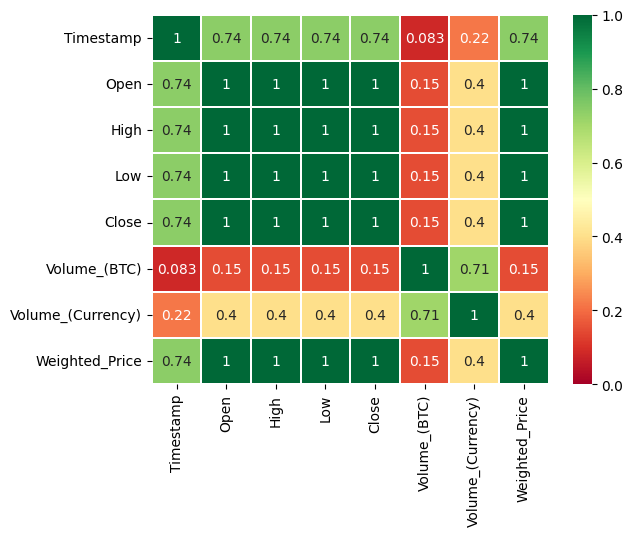

In [5]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
plt.show()


Observation: Volume is corrlerated to Weighted Price. 
    Open, High, Low, Close are directly related to Weighted Price

In [6]:
Real_Price.head()

date
2014-12-01    335.000000
2014-12-02    377.854911
2014-12-03    377.818333
2014-12-04    377.100000
2014-12-06    378.000000
Name: Weighted_Price, dtype: float64

Extrating the data of last 30 days as the test set

In [7]:
# split data
prediction_days = 30
df_train= Real_Price[:len(Real_Price)-prediction_days]
df_test= Real_Price[len(Real_Price)-prediction_days:]

In [8]:
len(df_train)

1435

In [9]:
len(df_test)

30

In [10]:
df_train.head()

date
2014-12-01    335.000000
2014-12-02    377.854911
2014-12-03    377.818333
2014-12-04    377.100000
2014-12-06    378.000000
Name: Weighted_Price, dtype: float64

# Data Preprocessing



### Feature scaling data to prepare input for Keras  

For an LSTM layer, you need the shape like (NumberOfExamples, TimeSteps, FeaturesPerStep).

Passing the tuple through np.reshape where np.reshape(a, newshape, order='C')
a-array to be reshaped
newshape= length of final set
order='C'-  C-like index ordering, in this case its 1 array

The order keyword gives the index ordering both for fetching the values from a,
and then placing the values into the output array. 
For example, let’s say you have an array:
* a = np.arange(6).reshape((3, 2))
* a
* Result will be :

array([[0, 1],
       [2, 3],
       [4, 5]])

In [13]:
# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
training_set

array([[ 335.        ],
       [ 377.85491071],
       [ 377.81833333],
       ...,
       [3694.95778355],
       [3358.48618463],
       [3384.38308658]])

In [14]:
type(training_set)

numpy.ndarray

As numpy has floting point value, no need of conversion. Othervise, ints are converted to floats because 
NN work better with them

## Scaling feature to a range: MinMaxScaler

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

As we have a numpy.array as an input data, we will be transforming features by scaling each feature to a 
given range. This estimator scales and translates each feature individually such that it is in the given 
range on the training set, i.e. between zero and one.

The transformation is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

where min, max = feature_range.


This transformation is often used as an alternative to zero mean, unit variance scaling.

* fit_transform= It gets fits- x_min and x_max, and then transform




### Feed Forward Net Vs RNN

In feed forward nets the hidden layers weights are adjusted based on the series of input values. But in RNN, recurrent neural net, the hidden layers weights are determined by Value at Time T , and Value at Time (T-1).

Here the preicted value is T+1 so we have taken value at T to be input which is building model by getting trained on Y_Train( which is T+1)

In [15]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))


X_train=t and y_train=t+1 pattern in the numbers. 

In [16]:
y_train

array([[0.01143791],
       [0.01143602],
       [0.01139896],
       ...,
       [0.18258932],
       [0.16522852],
       [0.16656471]])

In [17]:
X_train

array([[[0.00922674]],

       [[0.01143791]],

       [[0.01143602]],

       ...,

       [[0.18817346]],

       [[0.18258932]],

       [[0.16522852]]])

In [18]:
len(X_train)

1434

In [19]:
len(y_train)

1434

# Implementing Keras: Building the model

Why Keras?

* First, Keras is a wrapper that allows you to use either the Theano or the TensorFlow backend! That means you can easily switch between the two, depending on your application.

* Second, it has beautiful guiding principles: modularity, minimalism, extensibility, and Python-nativeness. In practice, this makes working in Keras simple and enjoyable.

* Finally, Keras has out-of-the-box implementations of common network structures. It’s fast and easy to get a convolutional neural network up and running.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons,
and an output layer that makes a single value prediction. The default sigmoid activation function is
used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.



Hyperparameters:
    
    Activation function: Sigmoid
    loss = 'mean_squared_error'
    optimizer = 'adam'

In [20]:
from keras.callbacks import TensorBoard

In [21]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM

regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)


Epoch 1/100
287/287 [==============================] - 2s 2ms/step - loss: 0.3801
Epoch 2/100
287/287 [==============================] - 1s 2ms/step - loss: 0.0819
Epoch 3/100
287/287 [==============================] - 0s 2ms/step - loss: 0.0457
Epoch 4/100
287/287 [==============================] - 0s 1ms/step - loss: 0.0388
Epoch 5/100
287/287 [==============================] - 0s 1ms/step - loss: 0.0338
Epoch 6/100
287/287 [==============================] - 0s 1ms/step - loss: 0.0292
Epoch 7/100
287/287 [==============================] - 1s 3ms/step - loss: 0.0248
Epoch 8/100
287/287 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 9/100
287/287 [==============================] - 1s 2ms/step - loss: 0.0167
Epoch 10/100
287/287 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 11/100
287/287 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 12/100
287/287 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 13/100


In [22]:
tb=TensorBoard(log_dir='C:/temp/tensorflow_logs/fig0')

history = regressor.fit(X_train, y_train, epochs=300, batch_size=100, validation_data=(X_train, y_train),
                        verbose=0, callbacks = [tb],shuffle=False)



Plot line graph to show amount loss according the the epoch


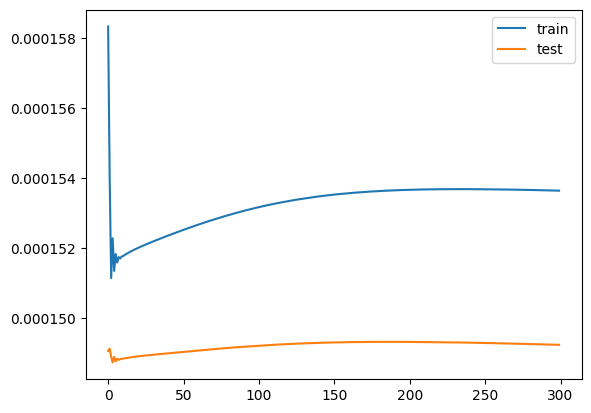

In [23]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

* **Prediction**

Notice that I only predict the price of the next day using the price today. Since there must be a lot of influence factors and it must have a lot of error when you predict a longer time.

### Transforming the test doing Reshape and then normalization.

Just the way input ata is transformed, output is tansformed to predict

In [25]:
# Making the predictions
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)


1/1 [==============================] - 0s 277ms/step


In [26]:
test_set

array([3468.66340323, 3469.77136553, 3365.44887029, 3396.44049554,
       3360.5018896 , 3234.10666065, 3179.78398822, 3217.44612111,
       3332.89962334, 3508.72890676, 3749.3306121 , 3924.28066696,
       3973.46851314, 3852.28373391, 3978.57450017, 4126.04952998,
       3773.67269197, 3775.0345208 , 3717.58629018, 3701.11710388,
       3874.10259264, 3788.85561692, 3756.53616803, 3700.53952816,
       3823.1521576 , 3829.90097845, 3785.33745641, 3834.56540111,
       3874.33796786, 4025.01761633])

In [27]:
predicted_BTC_price

array([[3388.933 ],
       [3390.0444],
       [3285.6858],
       [3316.6614],
       [3280.7427],
       [3154.6626],
       [3100.5955],
       [3138.0725],
       [3253.176 ],
       [3429.08  ],
       [3670.916 ],
       [3847.5466],
       [3897.3198],
       [3774.7793],
       [3902.4905],
       [4052.0317],
       [3695.4526],
       [3696.825 ],
       [3638.9355],
       [3622.3525],
       [3796.8218],
       [3710.7637],
       [3678.1777],
       [3621.7715],
       [3745.369 ],
       [3752.1812],
       [3707.216 ],
       [3756.89  ],
       [3797.0598],
       [3949.5374]], dtype=float32)

In [28]:
import math
from sklearn.metrics import mean_squared_error



In [29]:
X_train

array([[[0.00922674]],

       [[0.01143791]],

       [[0.01143602]],

       ...,

       [[0.18817346]],

       [[0.18258932]],

       [[0.16522852]]])

# Visualising
Plot the predicted price and the real price. Compare the diference. The difference is larger when the time is further to the training set. That is why I only want to predict the price of one month

# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

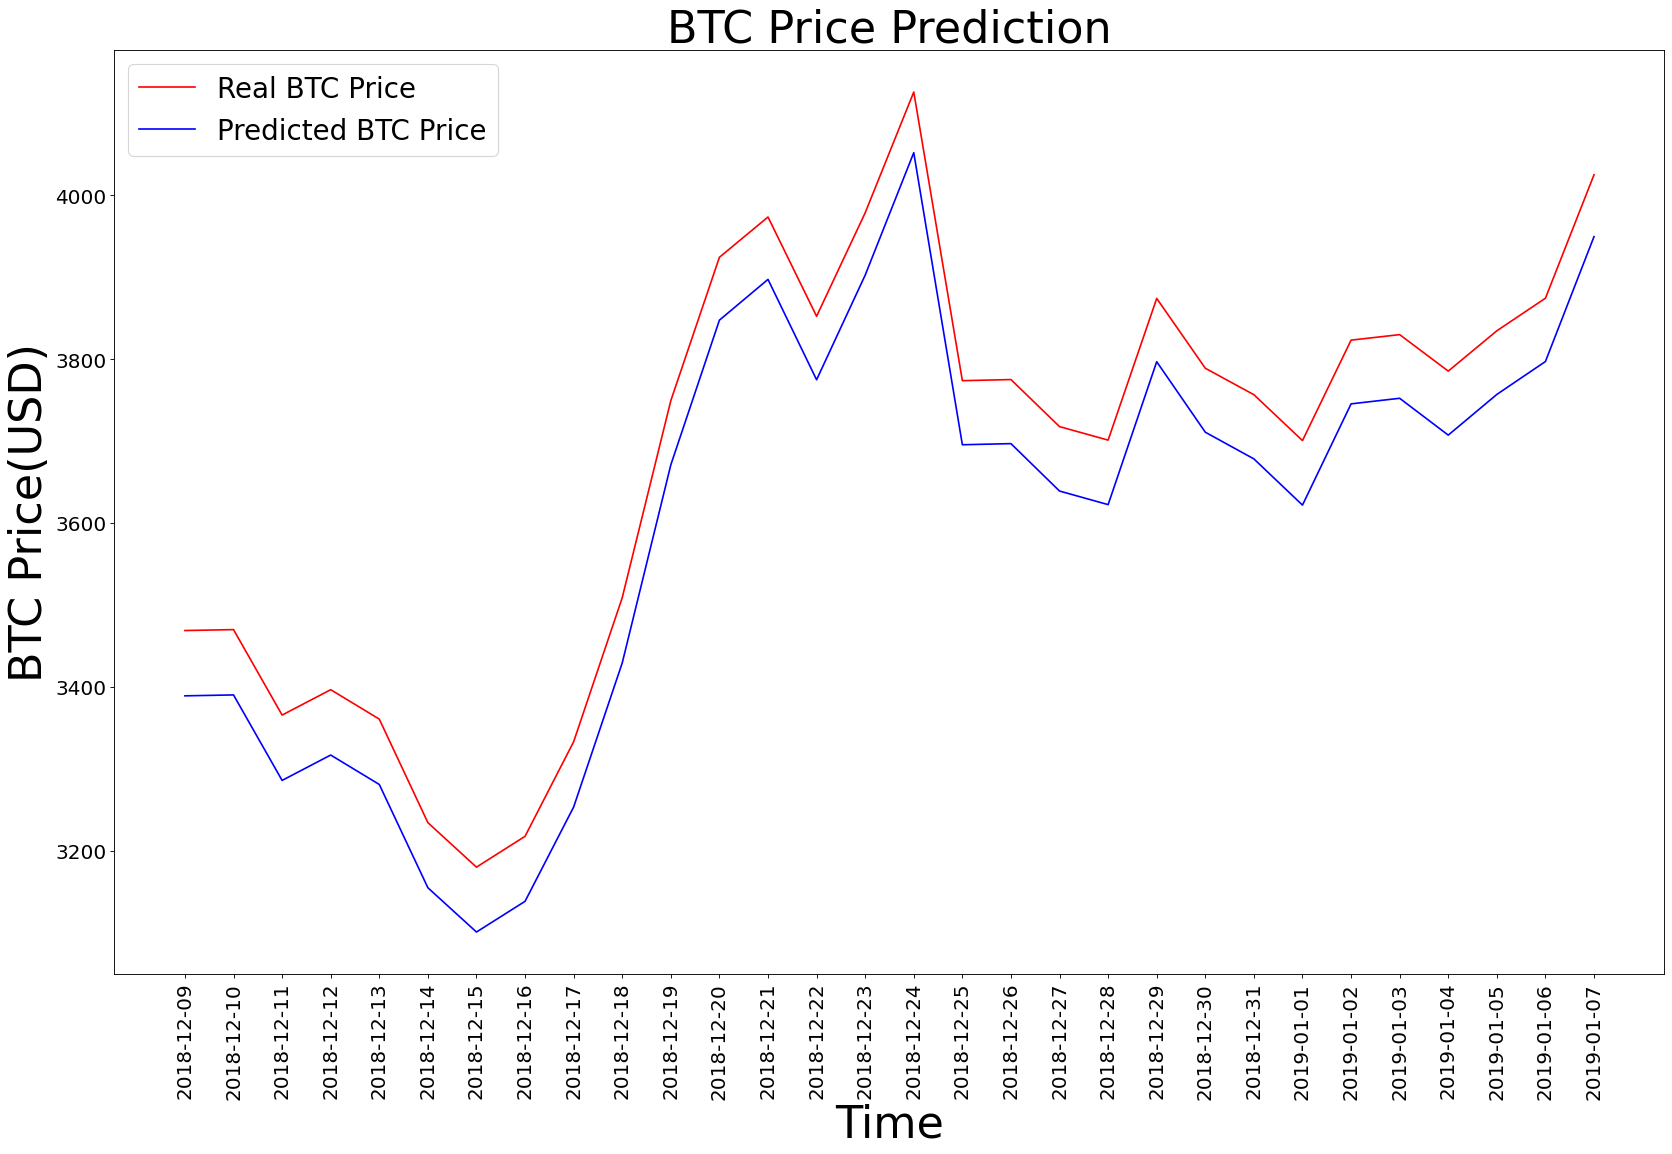

In [30]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

Saving log file for TensorBoard:

##### Go to command prompt and paste: tensorboard --logdir=C:\temp\tensorflow_logs --port 6060

In [31]:
tb=TensorBoard(log_dir='C:/temp/tensorflow_logs/fig2')

history = regressor.fit(X_train, y_train, epochs=300, batch_size=100, validation_data=(X_train, y_train),
                        verbose=0, callbacks = [tb],shuffle=False)



**Visualising**

Plot the predicted price and the real price. Compare the diference. The difference is larger when the time is further to the training set. So the prediction is done for only one month.

# Activation function - (ReLU)

###### relu(x, alpha=0.0, max_value=None)


In [32]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM

regressor.add(LSTM(units = 4, activation = 'relu', input_shape = (None, 1)))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 2, epochs = 100)


Epoch 1/100
717/717 [==============================] - 4s 2ms/step - loss: 0.0298
Epoch 2/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0098
Epoch 3/100
717/717 [==============================] - 2s 3ms/step - loss: 8.0932e-04
Epoch 4/100
717/717 [==============================] - 2s 2ms/step - loss: 2.7910e-04
Epoch 5/100
717/717 [==============================] - 2s 2ms/step - loss: 2.5989e-04
Epoch 6/100
717/717 [==============================] - 2s 2ms/step - loss: 2.5014e-04
Epoch 7/100
717/717 [==============================] - 2s 2ms/step - loss: 2.3436e-04
Epoch 8/100
717/717 [==============================] - 2s 2ms/step - loss: 2.1551e-04
Epoch 9/100
717/717 [==============================] - 2s 2ms/step - loss: 2.0376e-04
Epoch 10/100
717/717 [==============================] - 2s 2ms/step - loss: 1.8451e-04
Epoch 11/100
717/717 [==============================] - 2s 2ms/step - loss: 1.8942e-04
Epoch 12/100
717/717 [==============================] - 2s 2

## got the plateau

In [33]:
tb=TensorBoard(log_dir='C:/temp/tensorflow_logs/fig2')

history = regressor.fit(X_train, y_train, epochs=300, batch_size=100, validation_data=(X_train, y_train),
                        verbose=0, callbacks = [tb],shuffle=False)



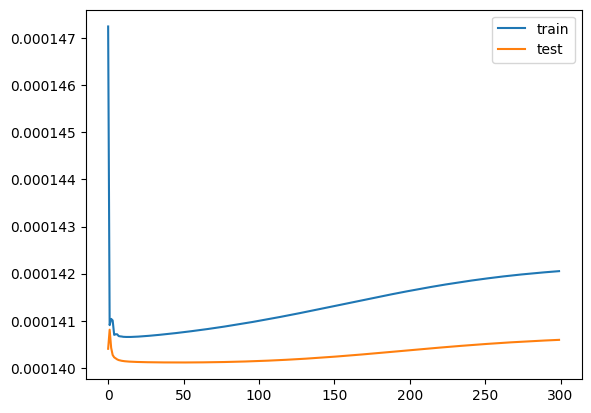

In [34]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
len(test_set)

30

In [36]:

predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)


1/1 [==============================] - 0s 245ms/step


In [37]:
predicted_BTC_price

array([[3487.6301],
       [3488.7378],
       [3384.387 ],
       [3415.3877],
       [3379.4385],
       [3253.    ],
       [3198.6558],
       [3236.333 ],
       [3351.8276],
       [3527.7046],
       [3768.3396],
       [3943.2903],
       [3992.4749],
       [3871.296 ],
       [3997.5803],
       [4145.0347],
       [3792.6829],
       [3794.045 ],
       [3736.5933],
       [3720.1226],
       [3893.115 ],
       [3807.8667],
       [3775.5457],
       [3719.5447],
       [3842.164 ],
       [3848.913 ],
       [3804.3484],
       [3853.5774],
       [3893.3494],
       [4044.018 ]], dtype=float32)

In [38]:
test_set

array([3468.66340323, 3469.77136553, 3365.44887029, 3396.44049554,
       3360.5018896 , 3234.10666065, 3179.78398822, 3217.44612111,
       3332.89962334, 3508.72890676, 3749.3306121 , 3924.28066696,
       3973.46851314, 3852.28373391, 3978.57450017, 4126.04952998,
       3773.67269197, 3775.0345208 , 3717.58629018, 3701.11710388,
       3874.10259264, 3788.85561692, 3756.53616803, 3700.53952816,
       3823.1521576 , 3829.90097845, 3785.33745641, 3834.56540111,
       3874.33796786, 4025.01761633])

In [39]:
import matplotlib.pyplot as plt
import numpy as np

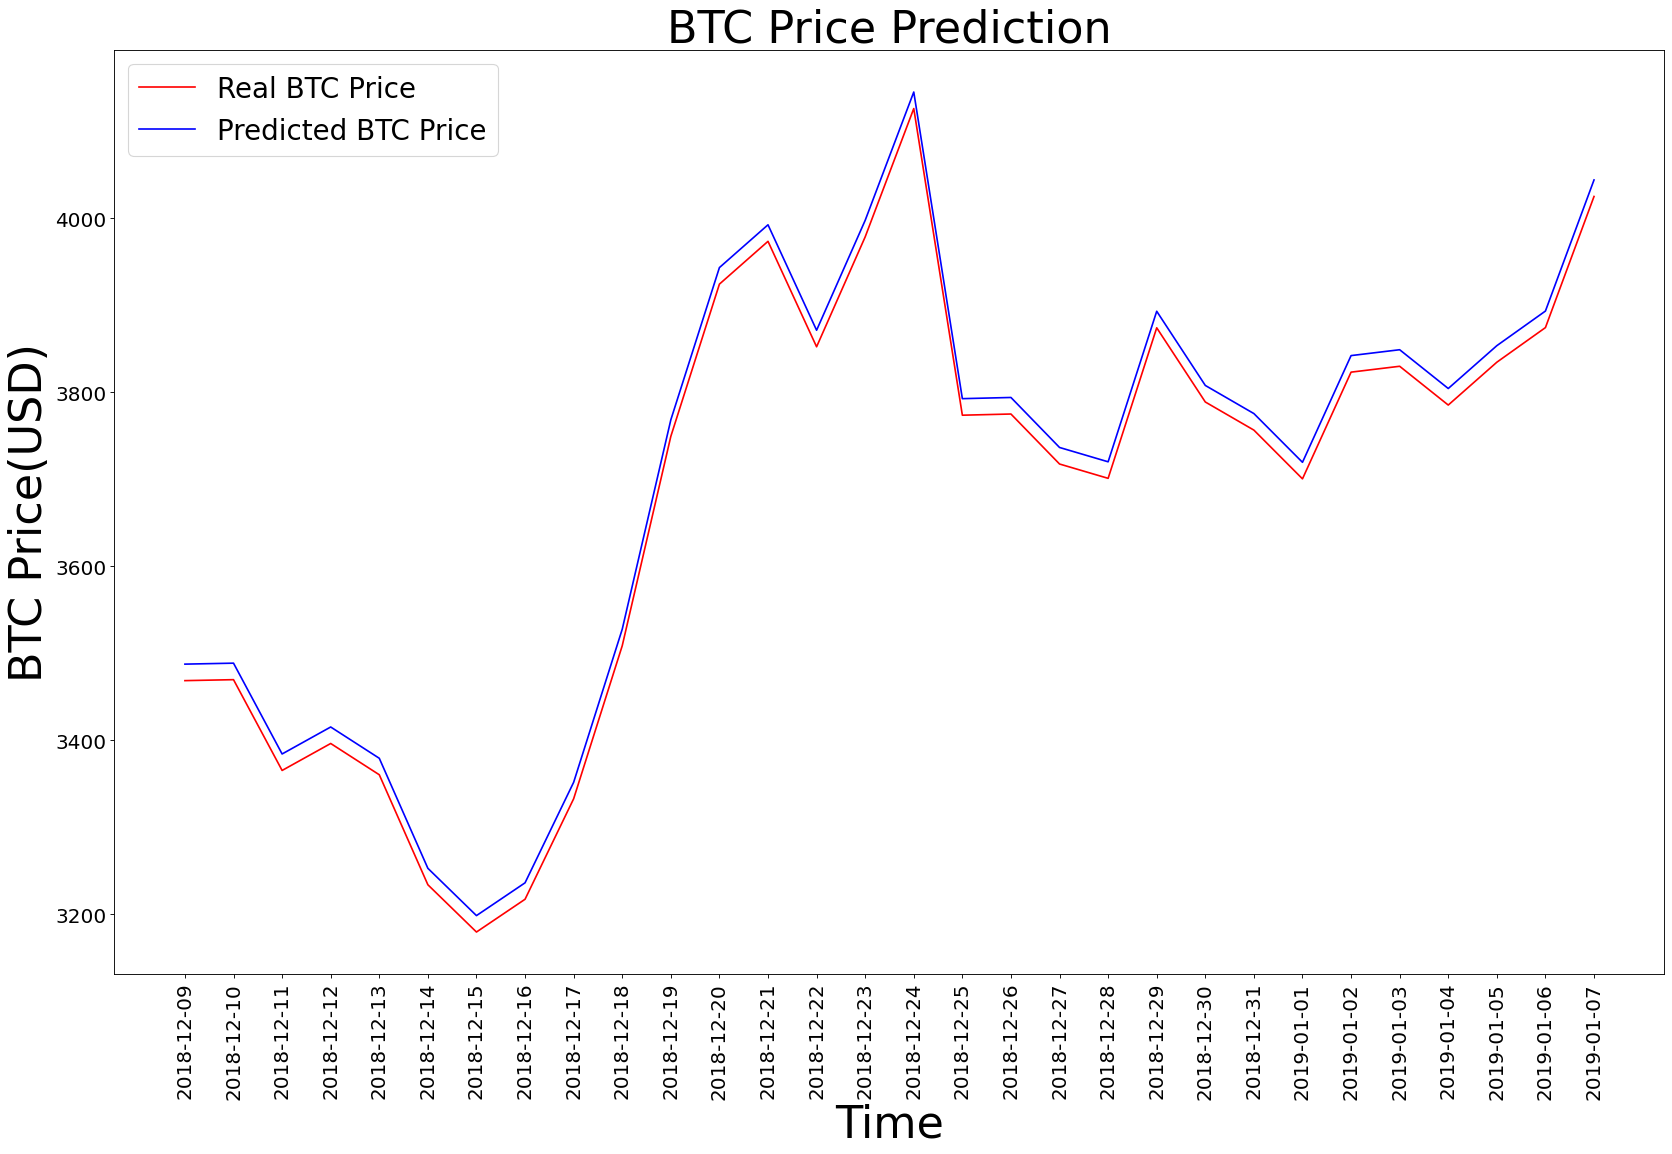

In [40]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)

labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

Planning to decrease the overfitting, have to increase the dropouts. 

# Dropout Regularization in Keras


 Dropout is easily implemented by randomly selecting nodes to be dropped-out with a given probability (e.g. 20%) each weight update cycle. This is how Dropout is implemented in Keras. Dropout is only used during the training of a model and is not used when evaluating the skill of the model.



In [41]:
from keras.layers import Dropout


In [42]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM
regressor.add(Dropout(0.2, input_shape = (None, 1)))


regressor.add(LSTM(units = 4, activation = 'softmax'))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1))


# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 2, epochs = 100)


Epoch 1/100
717/717 [==============================] - 4s 3ms/step - loss: 0.0372
Epoch 2/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0336
Epoch 3/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0295
Epoch 4/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0238
Epoch 5/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0151
Epoch 6/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0143
Epoch 7/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0132
Epoch 8/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0104
Epoch 9/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0120
Epoch 10/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0136
Epoch 11/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0109
Epoch 12/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0095
Epoch 13/100


In [43]:
tb=TensorBoard(log_dir='C:/temp/tensorflow_logs/fig3')

history = regressor.fit(X_train, y_train, epochs=300, batch_size=100, validation_data=(X_train, y_train),
                        verbose=0, callbacks = [tb],shuffle=False)



In [44]:

predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
predicted_BTC_price

1/1 [==============================] - 0s 220ms/step


array([[2337.6165],
       [2338.581 ],
       [2247.908 ],
       [2274.7979],
       [2243.6206],
       [2134.4358],
       [2087.747 ],
       [2120.1008],
       [2219.713 ],
       [2372.5554],
       [2583.6086],
       [2738.2527],
       [2781.8909],
       [2674.5044],
       [2786.425 ],
       [2917.6597],
       [2605.0708],
       [2606.2717],
       [2555.65  ],
       [2541.1582],
       [2693.8066],
       [2618.4666],
       [2589.9602],
       [2540.6494],
       [2648.7517],
       [2654.715 ],
       [2615.3616],
       [2658.837 ],
       [2694.015 ],
       [2827.693 ]], dtype=float32)

In [45]:
test_set

array([3468.66340323, 3469.77136553, 3365.44887029, 3396.44049554,
       3360.5018896 , 3234.10666065, 3179.78398822, 3217.44612111,
       3332.89962334, 3508.72890676, 3749.3306121 , 3924.28066696,
       3973.46851314, 3852.28373391, 3978.57450017, 4126.04952998,
       3773.67269197, 3775.0345208 , 3717.58629018, 3701.11710388,
       3874.10259264, 3788.85561692, 3756.53616803, 3700.53952816,
       3823.1521576 , 3829.90097845, 3785.33745641, 3834.56540111,
       3874.33796786, 4025.01761633])

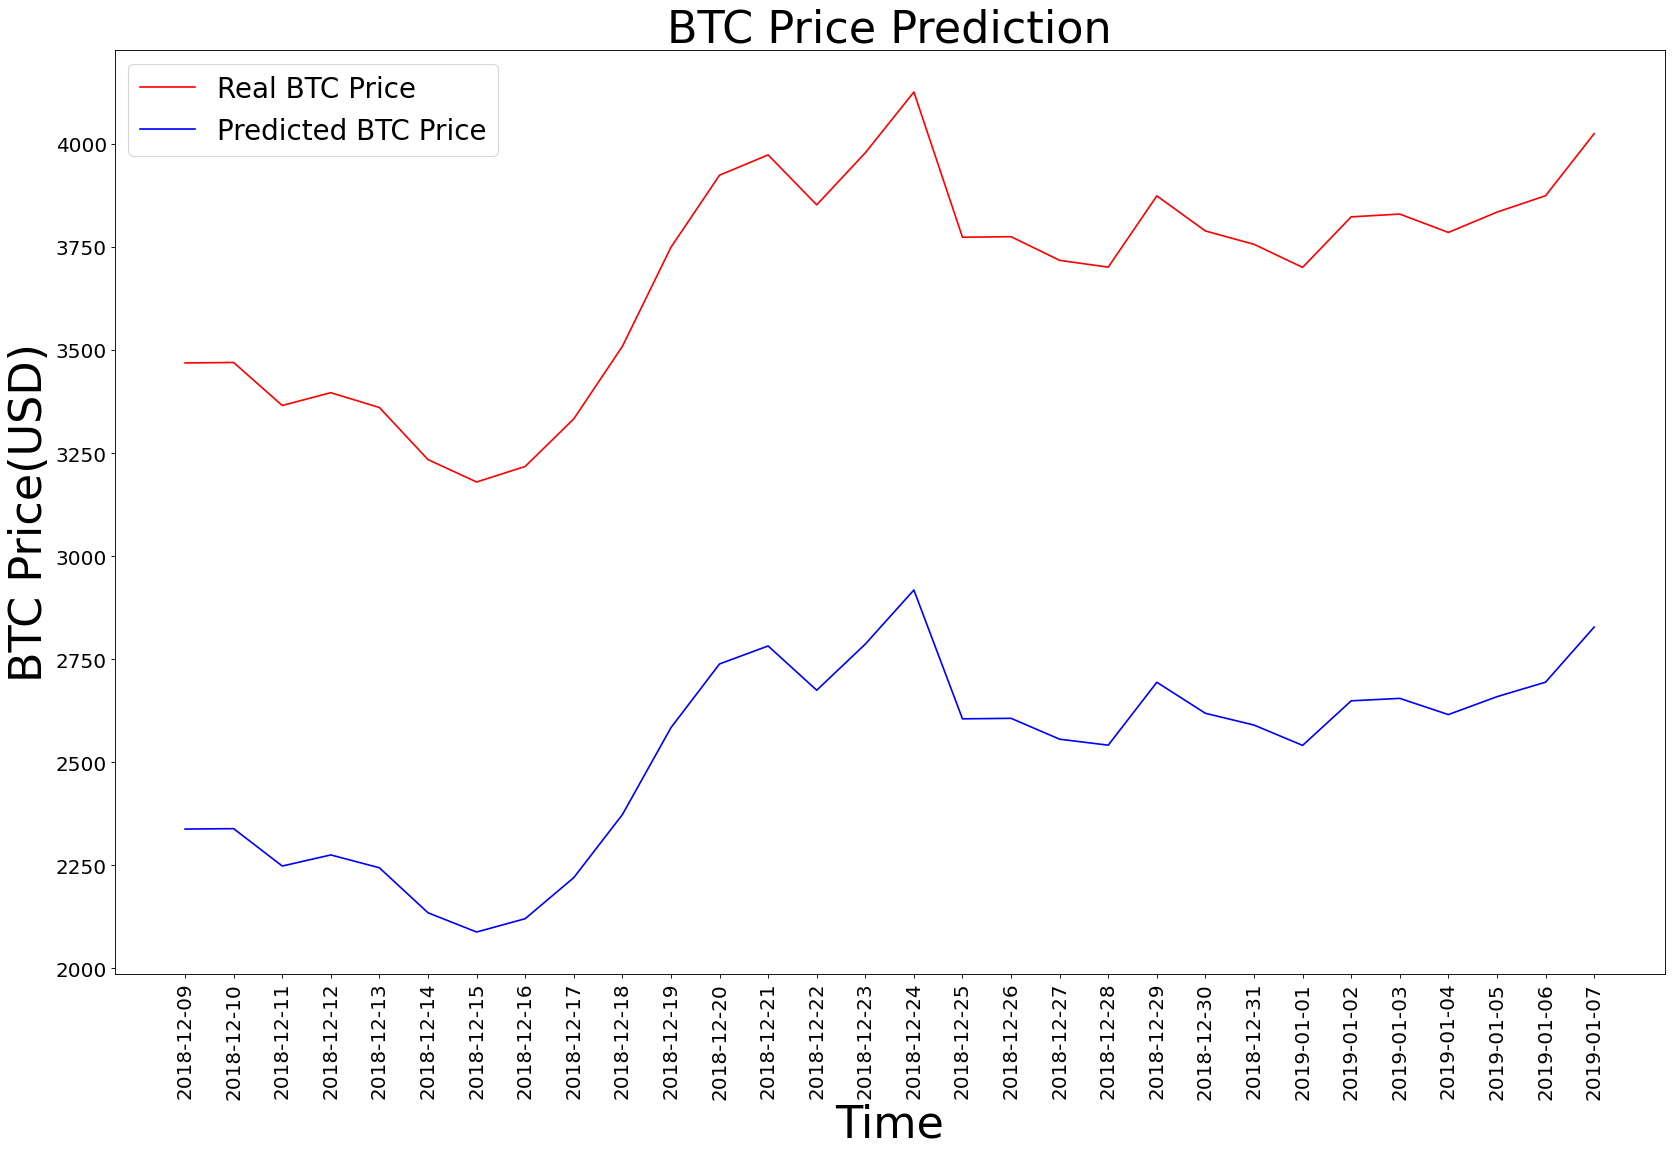

In [46]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)

labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

Need to decrease the Dropout

In [47]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM
regressor.add(Dropout(0.05, input_shape = (None, 1)))


regressor.add(LSTM(units = 4, activation = 'softmax'))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1))


# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 2, epochs = 100)


Epoch 1/100
717/717 [==============================] - 3s 2ms/step - loss: 0.0586
Epoch 2/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0305
Epoch 3/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0243
Epoch 4/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0174
Epoch 5/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0116
Epoch 6/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0078
Epoch 7/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0045
Epoch 8/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0047
Epoch 9/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0029
Epoch 10/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0037
Epoch 11/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0033
Epoch 12/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0032
Epoch 13/100


In [48]:
tb=TensorBoard(log_dir='C:/temp/tensorflow_logs/fig2')

history = regressor.fit(X_train, y_train, epochs=300, batch_size=100, validation_data=(X_train, y_train),
                        verbose=0, callbacks = [tb],shuffle=False)



In [49]:

predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
predicted_BTC_price

1/1 [==============================] - 0s 209ms/step


array([[3272.3142],
       [3273.3057],
       [3180.1265],
       [3207.773 ],
       [3175.7158],
       [3063.297 ],
       [3015.1353],
       [3048.5154],
       [3151.123 ],
       [3308.189 ],
       [3524.6738],
       [3683.2085],
       [3727.949 ],
       [3617.8545],
       [3732.5989],
       [3867.2065],
       [3546.6763],
       [3547.9075],
       [3496.0078],
       [3481.1497],
       [3637.6418],
       [3560.407 ],
       [3531.185 ],
       [3480.6282],
       [3591.4546],
       [3597.567 ],
       [3557.2253],
       [3601.7937],
       [3637.8552],
       [3774.9194]], dtype=float32)

In [50]:
test_set

array([3468.66340323, 3469.77136553, 3365.44887029, 3396.44049554,
       3360.5018896 , 3234.10666065, 3179.78398822, 3217.44612111,
       3332.89962334, 3508.72890676, 3749.3306121 , 3924.28066696,
       3973.46851314, 3852.28373391, 3978.57450017, 4126.04952998,
       3773.67269197, 3775.0345208 , 3717.58629018, 3701.11710388,
       3874.10259264, 3788.85561692, 3756.53616803, 3700.53952816,
       3823.1521576 , 3829.90097845, 3785.33745641, 3834.56540111,
       3874.33796786, 4025.01761633])

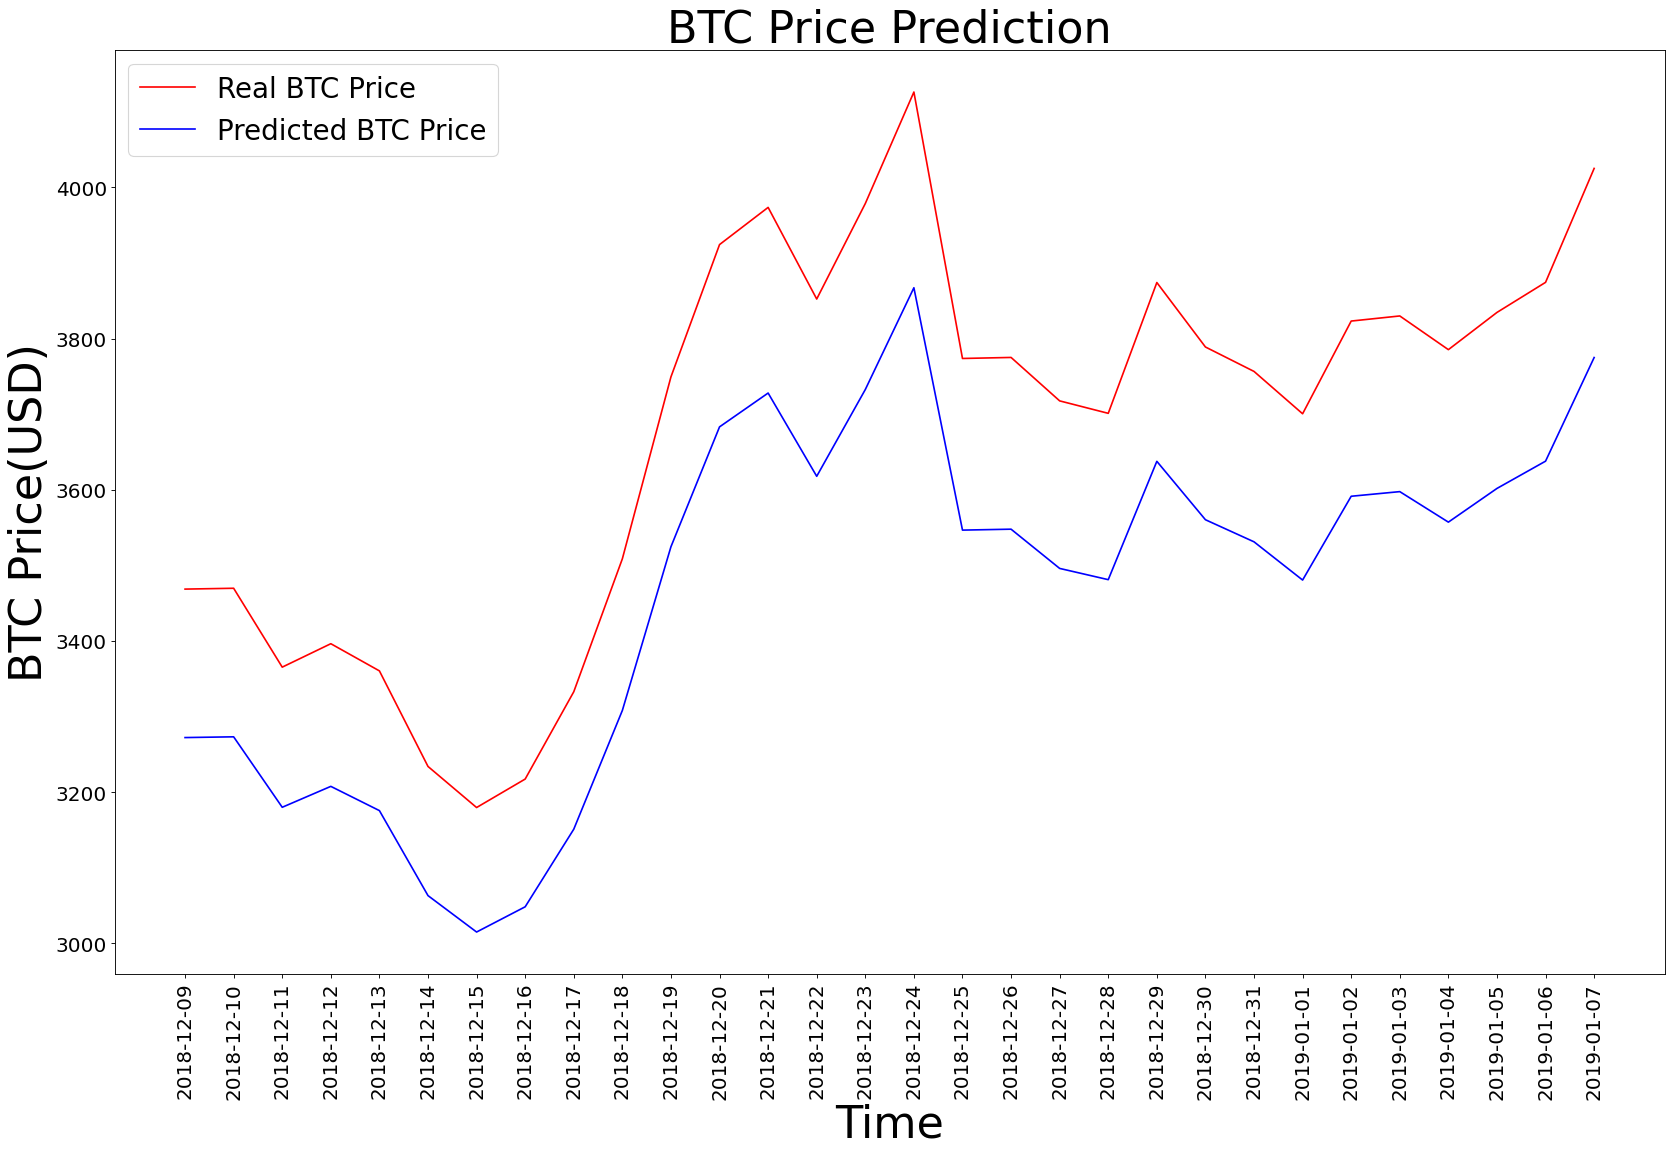

In [51]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)

labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

# Changing dropouts, epoches, batch size and cost function

In [52]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM
regressor.add(Dropout(0.6, input_shape = (None, 1)))


regressor.add(LSTM(units = 4, activation = 'relu'))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1))


# Compiling the RNN
regressor.compile(optimizer = 'adagrad', loss = 'mean_squared_error', metrics=['mae', 'acc'])

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 10, epochs = 50)


Epoch 1/50
144/144 [==============================] - 2s 2ms/step - loss: 0.0568 - mae: 0.1416 - acc: 6.9735e-04
Epoch 2/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0530 - mae: 0.1371 - acc: 6.9735e-04
Epoch 3/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0508 - mae: 0.1359 - acc: 6.9735e-04
Epoch 4/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0492 - mae: 0.1359 - acc: 6.9735e-04
Epoch 5/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0477 - mae: 0.1355 - acc: 6.9735e-04
Epoch 6/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0467 - mae: 0.1357 - acc: 6.9735e-04
Epoch 7/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0458 - mae: 0.1359 - acc: 6.9735e-04
Epoch 8/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0452 - mae: 0.1367 - acc: 6.9735e-04
Epoch 9/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0444 - mae: 0.1370 -

In [53]:

predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
predicted_BTC_price

1/1 [==============================] - 0s 195ms/step


array([[2590.343 ],
       [2590.4114],
       [2583.9658],
       [2585.8792],
       [2583.6606],
       [2575.8691],
       [2572.526 ],
       [2574.8433],
       [2581.9573],
       [2592.8218],
       [2607.746 ],
       [2618.6404],
       [2621.7102],
       [2614.1528],
       [2622.0288],
       [2631.2495],
       [2609.2598],
       [2609.3445],
       [2605.7732],
       [2604.75  ],
       [2615.5122],
       [2610.2043],
       [2608.194 ],
       [2604.714 ],
       [2612.3389],
       [2612.7588],
       [2609.9854],
       [2613.0493],
       [2615.5269],
       [2624.9297]], dtype=float32)

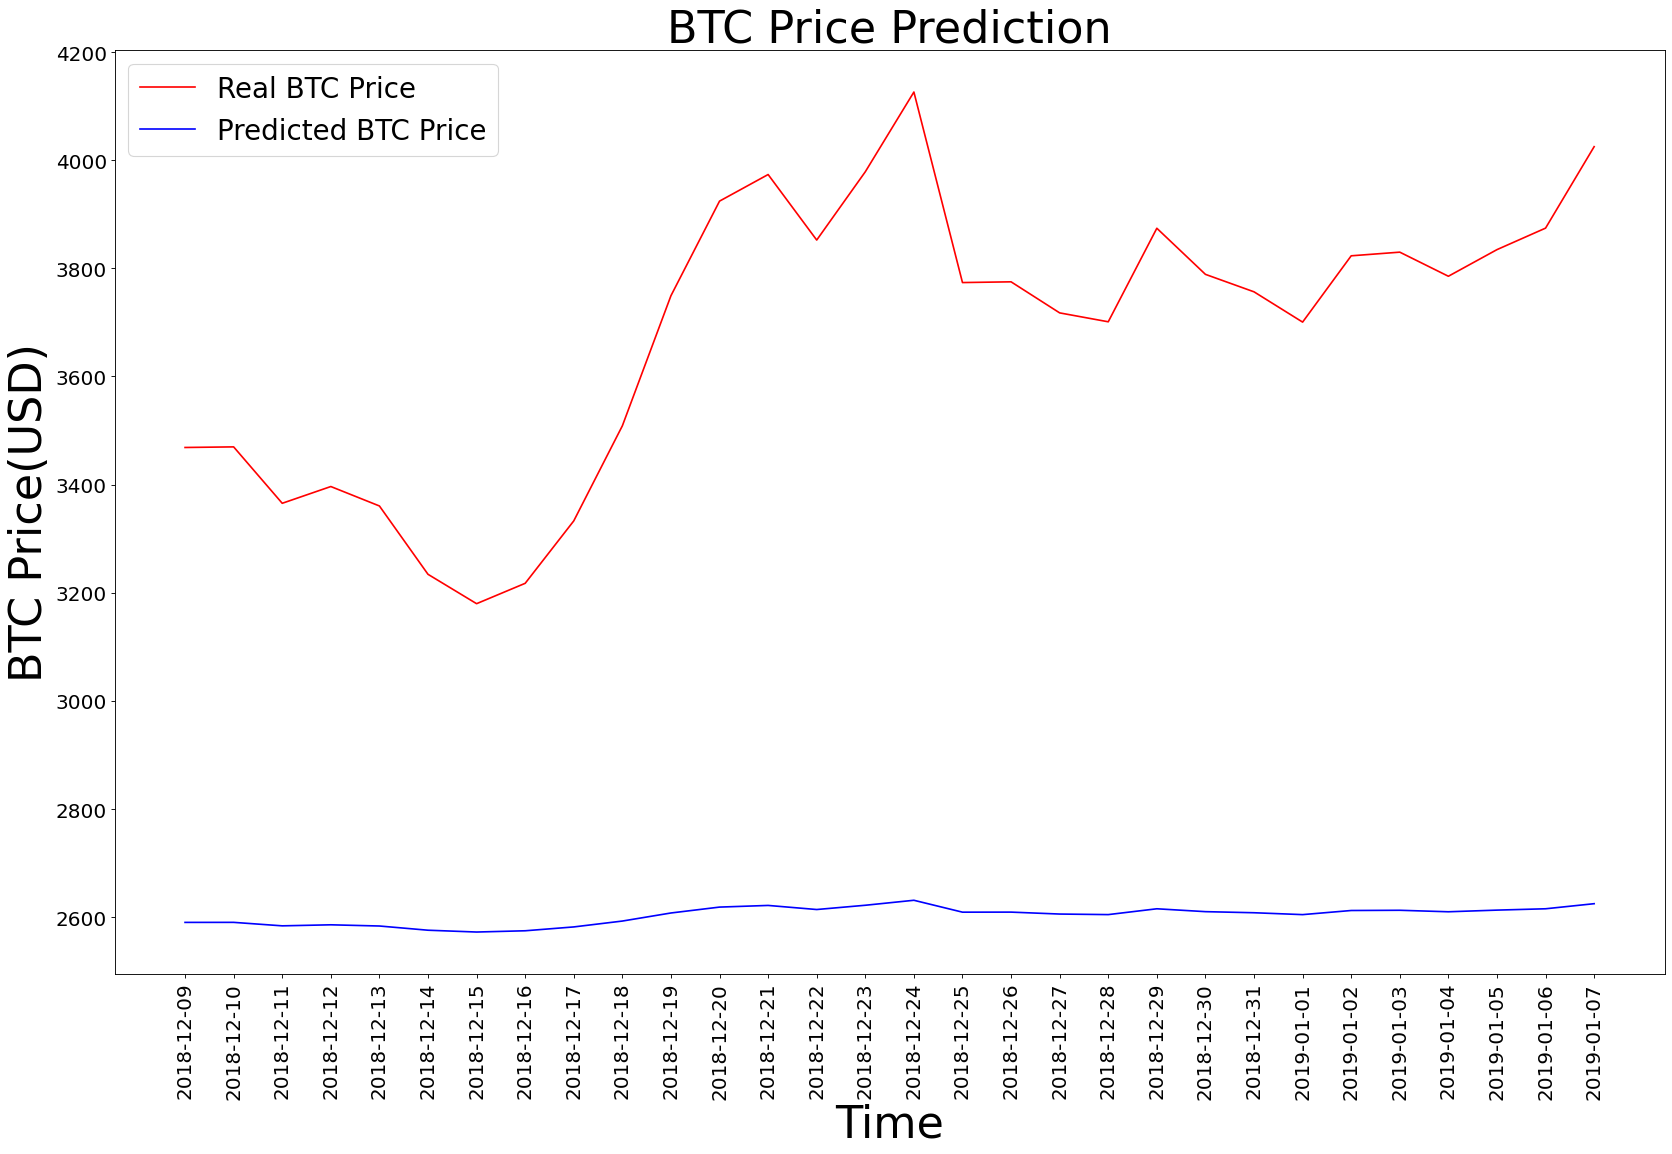

In [54]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)

labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

# REMOVING THE DROPOUT LAYER and Changing to ADAM optimizer

Adam is an optimization algorithm that can used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.


Adam is different to classical stochastic gradient descent.

Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

In [55]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM


regressor.add(LSTM(units = 4, activation = 'relu', input_shape = (None, 1)))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1))


# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'acc'])


# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 2, epochs = 100)


Epoch 1/100
717/717 [==============================] - 3s 3ms/step - loss: 0.0404 - mae: 0.1511 - acc: 6.9735e-04
Epoch 2/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0154 - mae: 0.1027 - acc: 6.9735e-04
Epoch 3/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0015 - mae: 0.0305 - acc: 0.0014
Epoch 4/100
717/717 [==============================] - 2s 2ms/step - loss: 2.6586e-04 - mae: 0.0103 - acc: 0.0014
Epoch 5/100
717/717 [==============================] - 2s 2ms/step - loss: 2.4037e-04 - mae: 0.0092 - acc: 0.0014
Epoch 6/100
717/717 [==============================] - 2s 2ms/step - loss: 2.2214e-04 - mae: 0.0084 - acc: 0.0014
Epoch 7/100
717/717 [==============================] - 2s 3ms/step - loss: 1.9567e-04 - mae: 0.0079 - acc: 0.0014
Epoch 8/100
717/717 [==============================] - 2s 3ms/step - loss: 1.8446e-04 - mae: 0.0070 - acc: 0.0014
Epoch 9/100
717/717 [==============================] - 2s 2ms/step - loss: 1.7565e-04 - mae:

In [56]:
from keras.callbacks import Callback,TensorBoard, ModelCheckpoint

In [57]:
tb=TensorBoard(log_dir='C:/temp/tensorflow_logs/fig1')

history = regressor.fit(X_train, y_train, epochs=300, batch_size=100, validation_data=(X_train, y_train),
                        verbose=0, callbacks = [tb],shuffle=False)



In [58]:

predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
predicted_BTC_price


1/1 [==============================] - 0s 194ms/step


array([[3480.8733],
       [3481.98  ],
       [3377.768 ],
       [3408.7258],
       [3372.8271],
       [3246.58  ],
       [3192.3254],
       [3229.9404],
       [3345.256 ],
       [3520.8984],
       [3761.292 ],
       [3936.123 ],
       [3985.2822],
       [3864.1714],
       [3990.3857],
       [4137.7896],
       [3785.6157],
       [3786.9758],
       [3729.572 ],
       [3713.1155],
       [3885.976 ],
       [3800.7876],
       [3768.4922],
       [3712.5383],
       [3835.0596],
       [3841.8037],
       [3797.2717],
       [3846.4646],
       [3886.2114],
       [4036.8044]], dtype=float32)

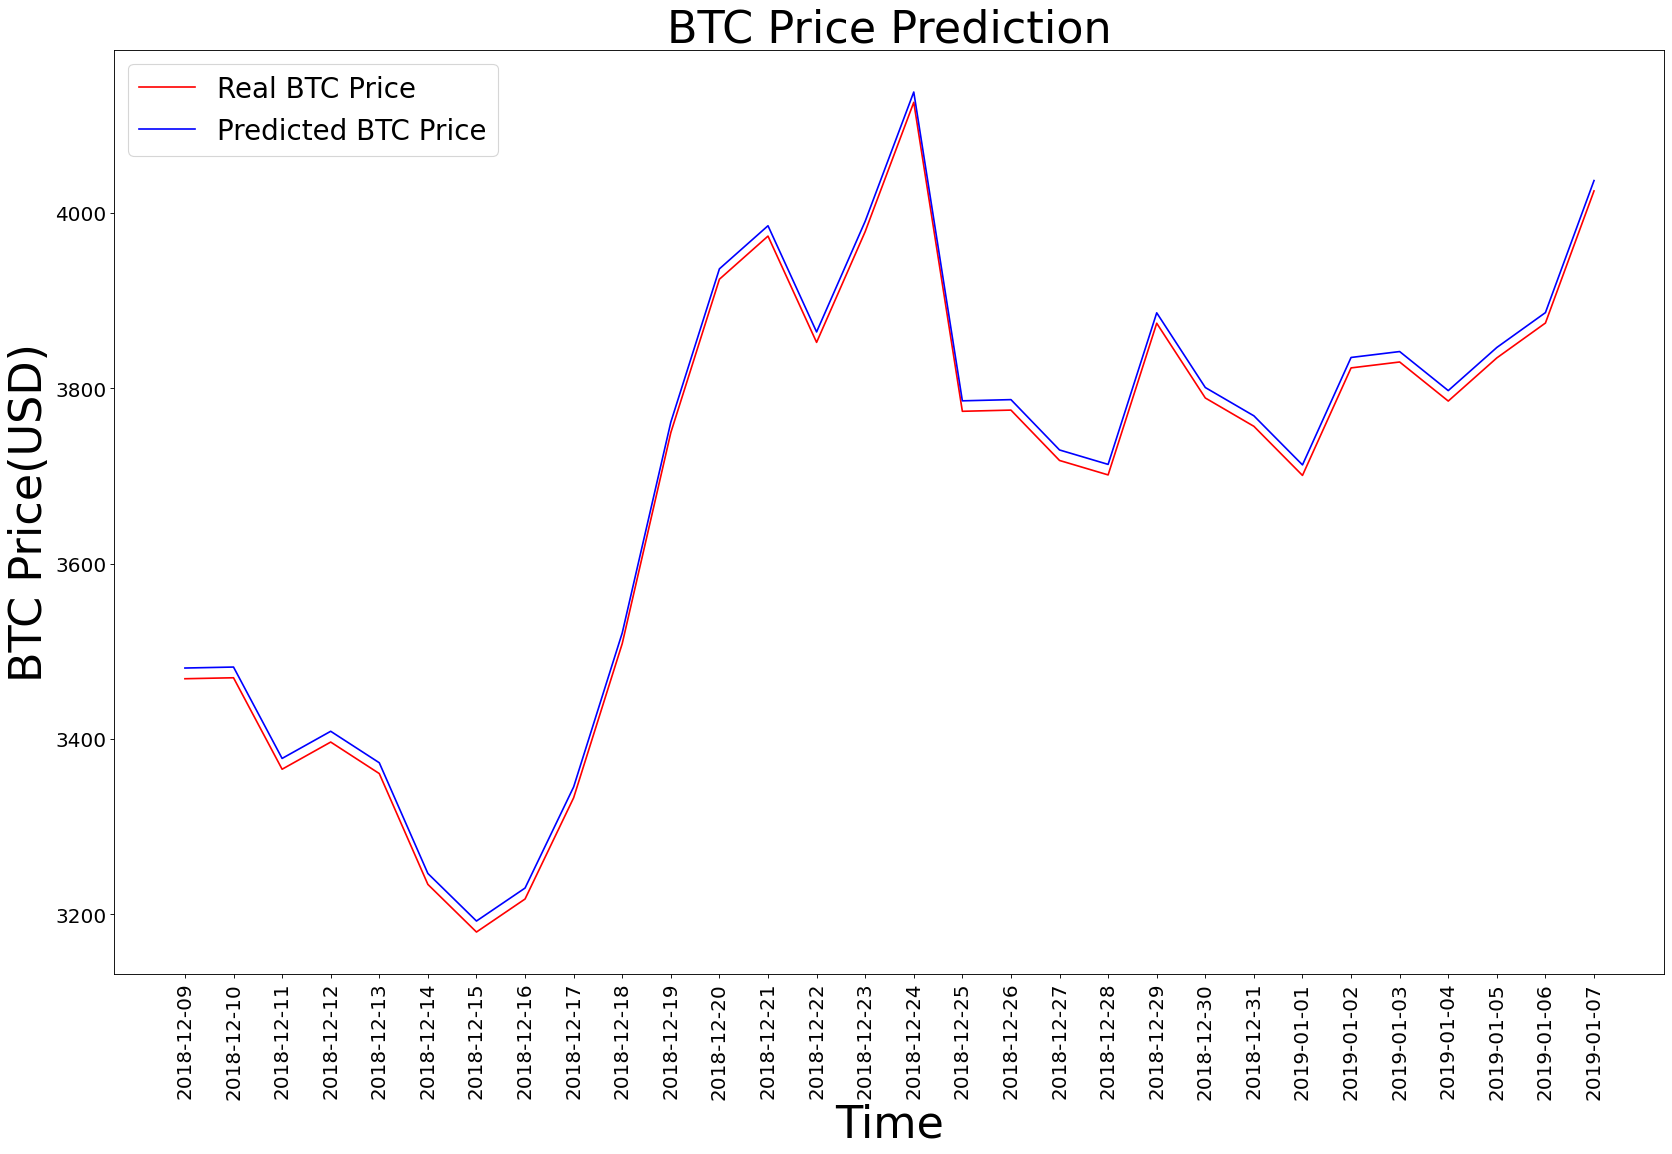

In [59]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)

labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

In [60]:
from keras.callbacks import ModelCheckpoint


# Cost function and  Epoches

In [61]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM

regressor.add(LSTM(units = 4, activation = 'softmax', input_shape = (None, 1)))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 2, epochs = 90)


Epoch 1/90
717/717 [==============================] - 3s 2ms/step - loss: 2.3298 - accuracy: 6.9735e-04
Epoch 2/90
717/717 [==============================] - 2s 2ms/step - loss: 2.3298 - accuracy: 6.9735e-04
Epoch 3/90
717/717 [==============================] - 2s 2ms/step - loss: 2.3298 - accuracy: 6.9735e-04
Epoch 4/90
717/717 [==============================] - 2s 2ms/step - loss: 2.3298 - accuracy: 6.9735e-04
Epoch 5/90
717/717 [==============================] - 2s 2ms/step - loss: 2.3298 - accuracy: 6.9735e-04
Epoch 6/90
717/717 [==============================] - 2s 2ms/step - loss: 2.3298 - accuracy: 6.9735e-04
Epoch 7/90
717/717 [==============================] - 2s 2ms/step - loss: 2.3298 - accuracy: 6.9735e-04
Epoch 8/90
717/717 [==============================] - 2s 2ms/step - loss: 2.3298 - accuracy: 6.9735e-04
Epoch 9/90
717/717 [==============================] - 2s 2ms/step - loss: 2.3298 - accuracy: 6.9735e-04
Epoch 10/90
717/717 [==============================] - 2s 2ms/st

In [62]:
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
predicted_BTC_price

1/1 [==============================] - 0s 223ms/step


array([[-37.23024 ],
       [-37.247425],
       [-35.62754 ],
       [-36.10868 ],
       [-35.550716],
       [-33.587234],
       [-32.743286],
       [-33.328575],
       [-35.1221  ],
       [-37.852028],
       [-41.58478 ],
       [-44.296696],
       [-45.058987],
       [-43.180767],
       [-45.1379  ],
       [-47.422134],
       [-41.96203 ],
       [-41.983326],
       [-41.09245 ],
       [-40.836967],
       [-43.5191  ],
       [-42.19751 ],
       [-41.69655 ],
       [-40.828125],
       [-42.7293  ],
       [-42.833992],
       [-42.14311 ],
       [-42.90619 ],
       [-43.522816],
       [-45.85741 ]], dtype=float32)

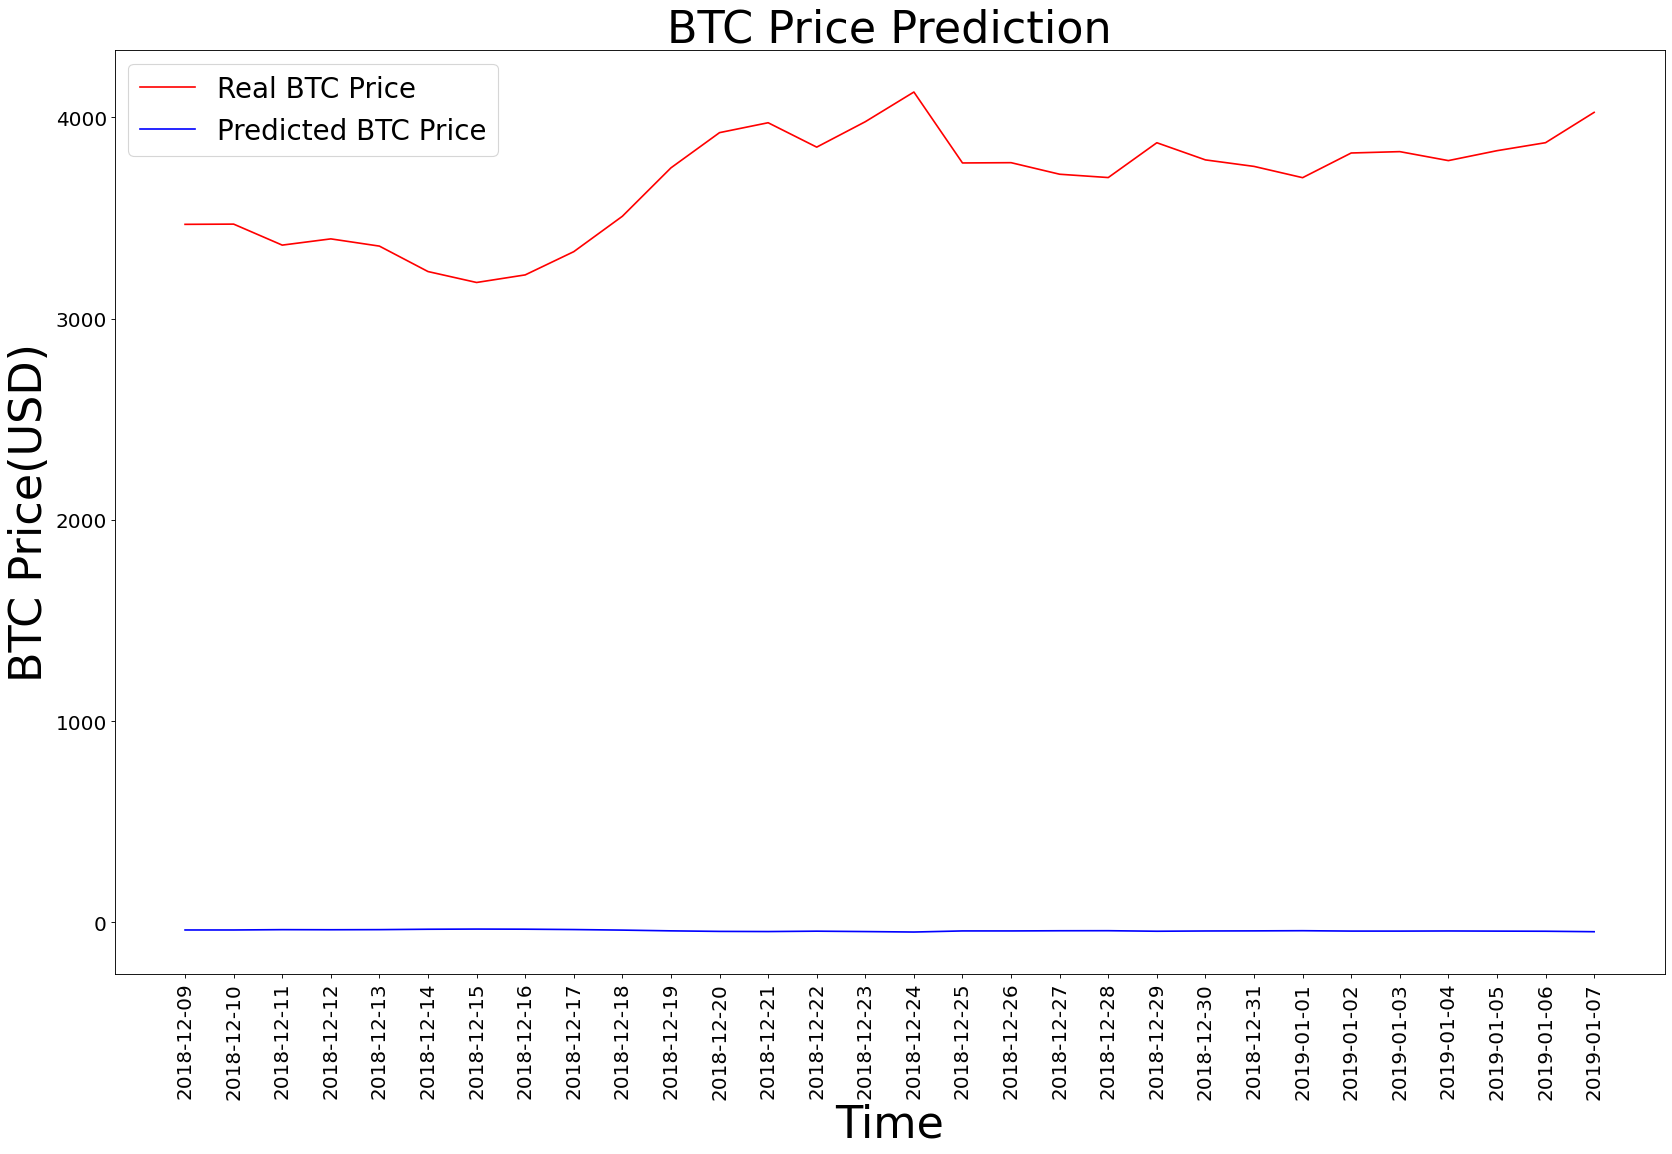

In [63]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

Achieving plateau !

# Gradient estimation and Network Architecture

In [64]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM

regressor.add(LSTM(units = 4, activation = 'softmax', input_shape = (None, 1)))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 3, epochs = 200)


Epoch 1/200
478/478 [==============================] - 2s 2ms/step - loss: 0.0395
Epoch 2/200
478/478 [==============================] - 1s 2ms/step - loss: 0.0357
Epoch 3/200
478/478 [==============================] - 1s 2ms/step - loss: 0.0318
Epoch 4/200
478/478 [==============================] - 1s 2ms/step - loss: 0.0269
Epoch 5/200
478/478 [==============================] - 1s 2ms/step - loss: 0.0204
Epoch 6/200
478/478 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 7/200
478/478 [==============================] - 1s 2ms/step - loss: 0.0067
Epoch 8/200
478/478 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 9/200
478/478 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 10/200
478/478 [==============================] - 1s 2ms/step - loss: 6.0133e-04
Epoch 11/200
478/478 [==============================] - 1s 2ms/step - loss: 4.6516e-04
Epoch 12/200
478/478 [==============================] - 1s 2ms/step - loss: 3.9189e-04
E

In [65]:
regressor.summary() #current model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 4)                 96        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [66]:
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
predicted_BTC_price

1/1 [==============================] - 0s 224ms/step


array([[3471.7383],
       [3472.856 ],
       [3367.544 ],
       [3398.8154],
       [3362.5535],
       [3235.1606],
       [3180.4778],
       [3218.3853],
       [3334.7144],
       [3512.22  ],
       [3755.7432],
       [3933.2427],
       [3983.207 ],
       [3860.1545],
       [3988.3955],
       [4138.3594],
       [3780.4202],
       [3781.7996],
       [3723.5737],
       [3706.888 ],
       [3882.2988],
       [3795.8137],
       [3763.0476],
       [3706.3052],
       [3830.5986],
       [3837.4456],
       [3792.2466],
       [3842.1772],
       [3882.5374],
       [4035.5994]], dtype=float32)

1/1 [==============================] - 0s 24ms/step


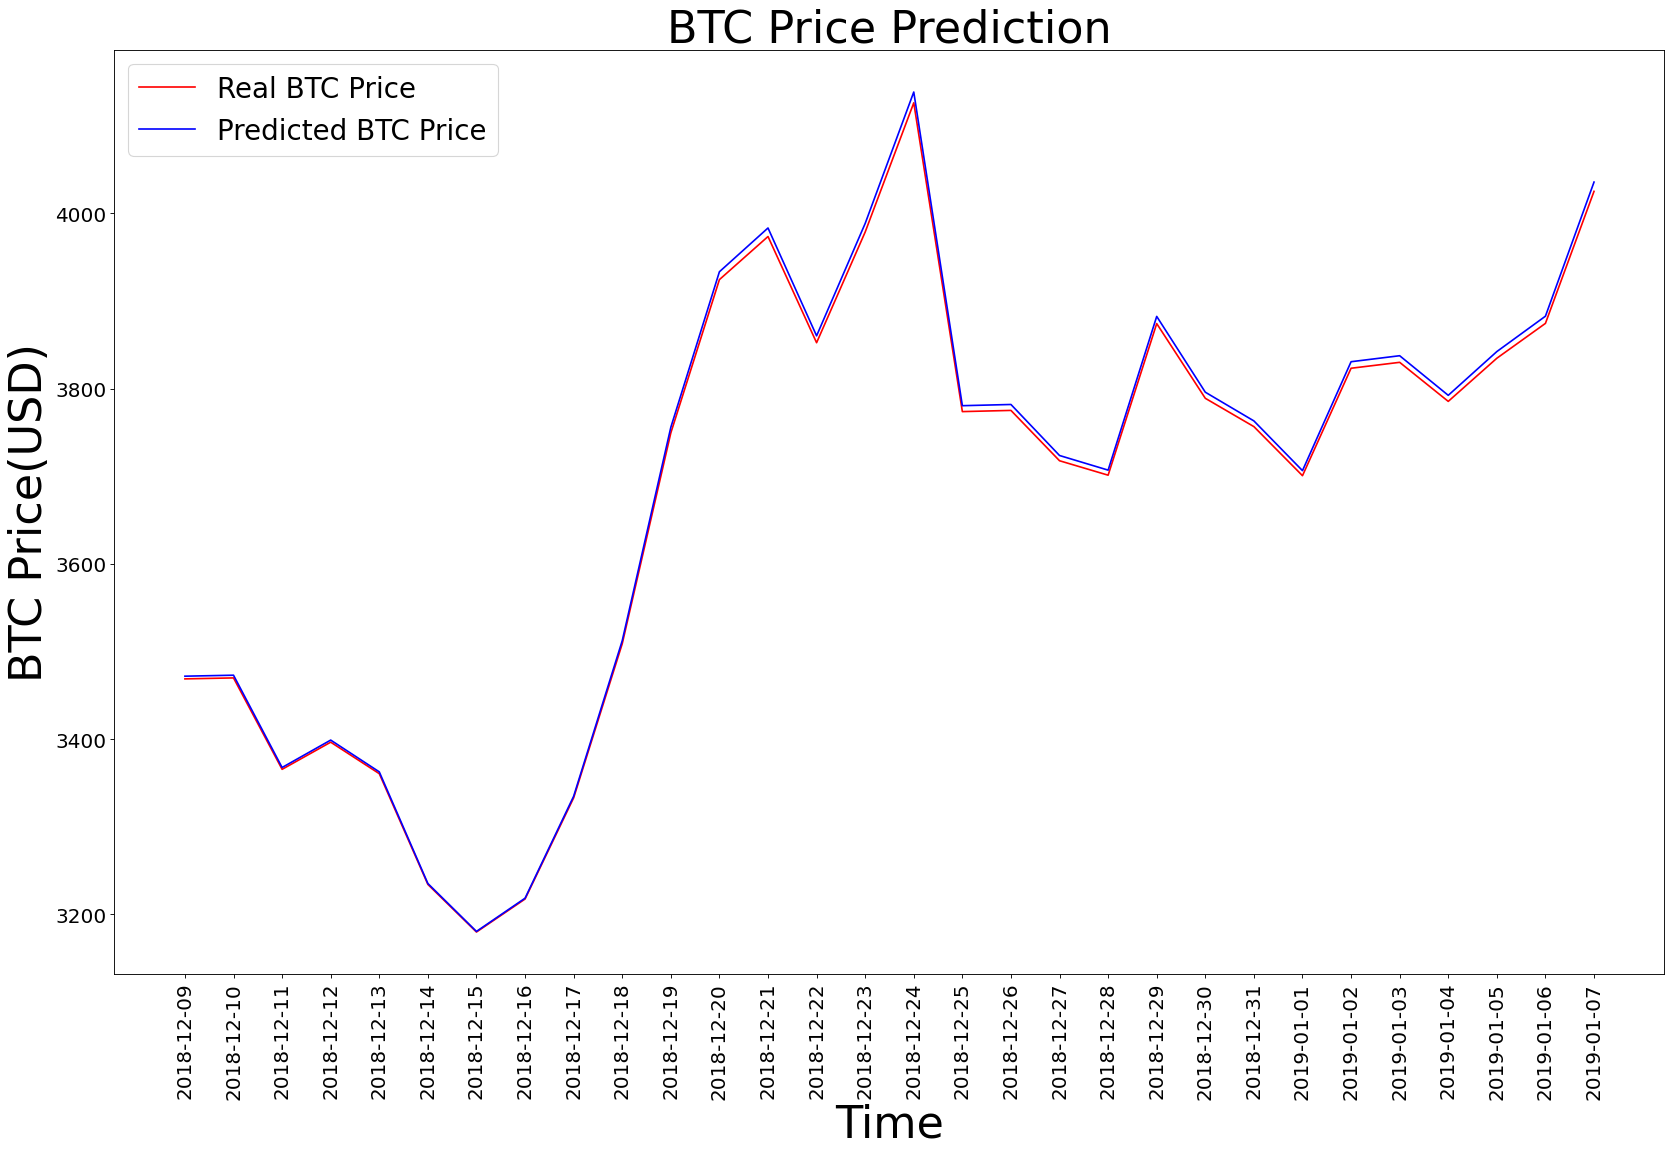

In [67]:

predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

In [68]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM

regressor.add(LSTM(units = 3, activation = 'softmax', input_shape = (None, 1)))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 2, epochs = 100)


Epoch 1/100
717/717 [==============================] - 3s 2ms/step - loss: 0.0453
Epoch 2/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0335
Epoch 3/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0281
Epoch 4/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0213
Epoch 5/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0141
Epoch 6/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0079
Epoch 7/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0038
Epoch 8/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 9/100
717/717 [==============================] - 1s 2ms/step - loss: 8.6041e-04
Epoch 10/100
717/717 [==============================] - 1s 2ms/step - loss: 5.8877e-04
Epoch 11/100
717/717 [==============================] - 1s 2ms/step - loss: 4.7590e-04
Epoch 12/100
717/717 [==============================] - 1s 2ms/step - loss: 4.2110e-

In [69]:
regressor.summary() #current model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3)                 60        
                                                                 
 dense_8 (Dense)             (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


##### Conclusion: Nodes are increased to 50 but it lead to decrease in the performance while training on 10 epoches

In [70]:

predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
predicted_BTC_price

1/1 [==============================] - 0s 277ms/step


array([[3265.8948],
       [3266.999 ],
       [3163.2861],
       [3194.0608],
       [3158.3752],
       [3033.1929],
       [2979.5486],
       [3016.7324],
       [3130.9946],
       [3305.8127],
       [3546.5364],
       [3722.6196],
       [3772.276 ],
       [3650.0542],
       [3777.4363],
       [3926.7278],
       [3570.9841],
       [3572.353 ],
       [3514.6794],
       [3498.1636],
       [3672.0286],
       [3586.242 ],
       [3553.7703],
       [3497.5835],
       [3620.7317],
       [3627.522 ],
       [3582.7048],
       [3632.2156],
       [3672.2654],
       [3824.3894]], dtype=float32)

1/1 [==============================] - 0s 26ms/step


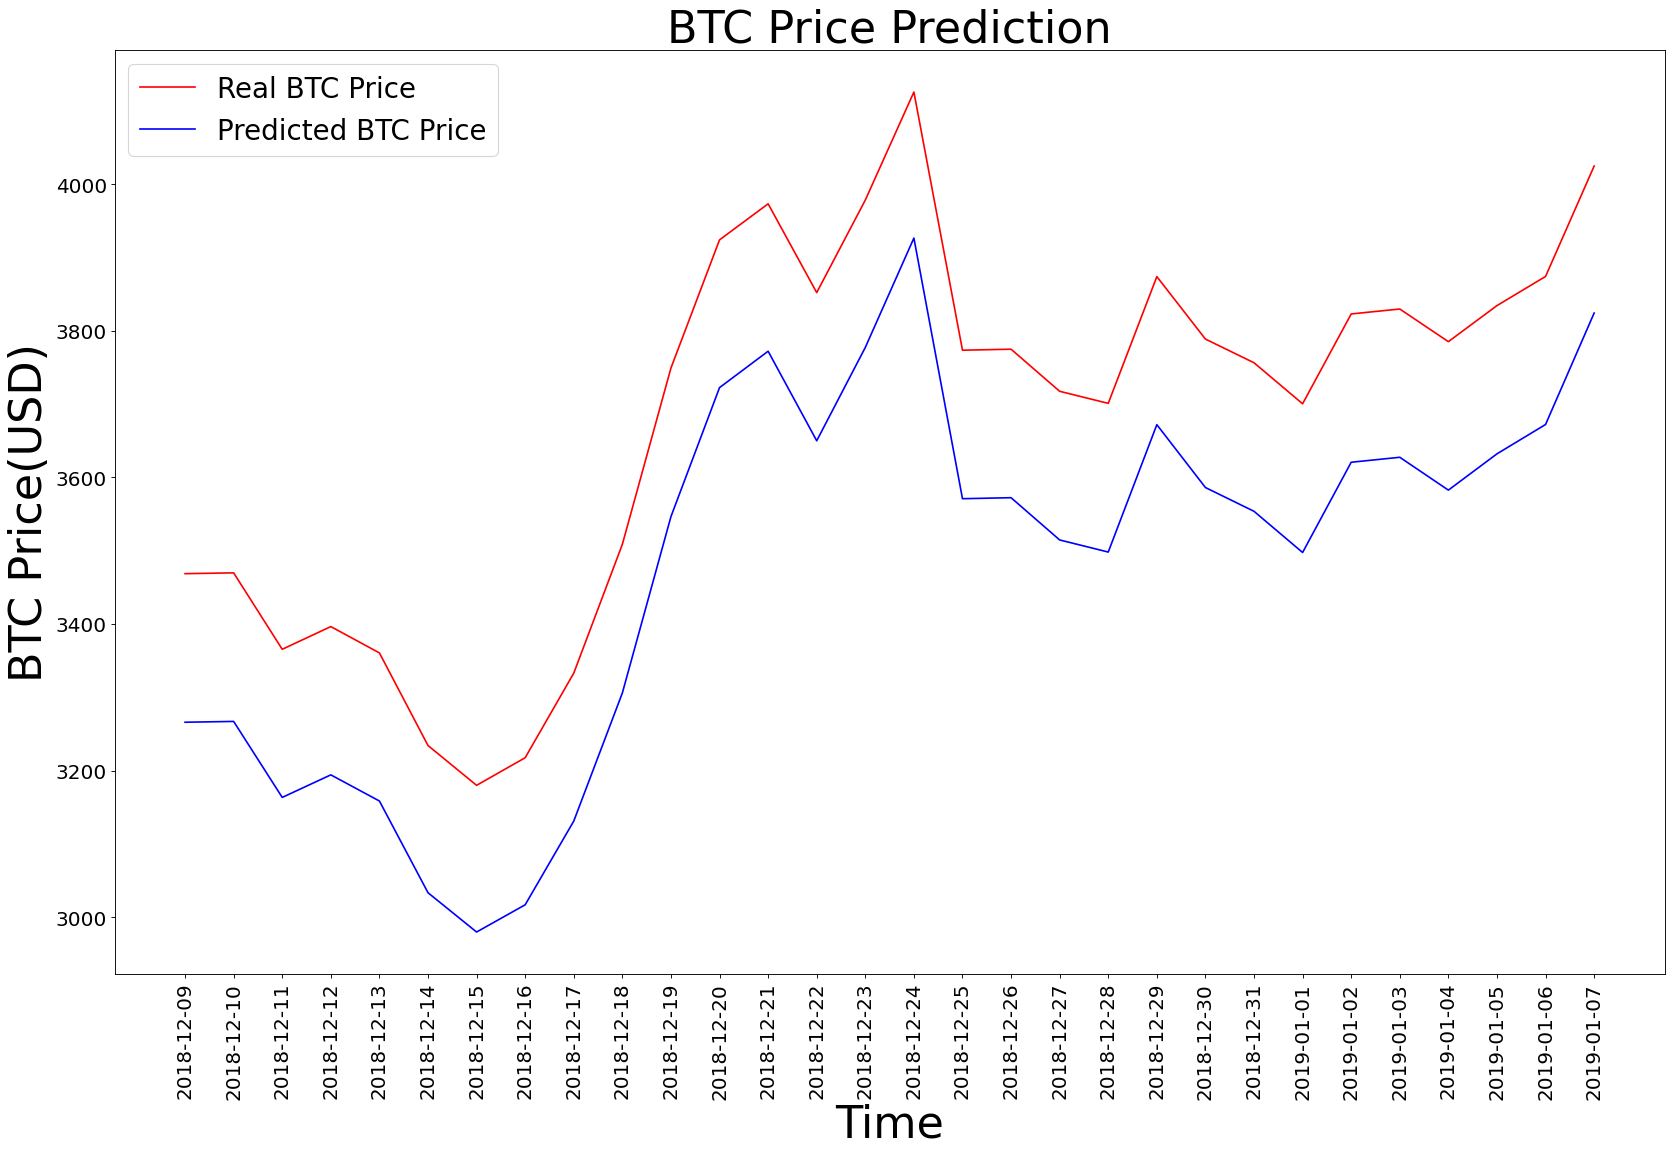

In [71]:

predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

The ultimate goal is too obtain a net that performs well on non-training data that comes from the same or
similar source as the training data. This is called GENERALIZATION.



# Network initialization

#### Usage of initializations

Initializations define the way to set the initial random weights of Keras layers.



##### Available initializations:
<dl>
    <dd>uniform</dd>
    <dd>lecun_uniform: Uniform initialization scaled by the square root of the number of inputs (LeCun 98).
    normal</dd>
    <dd>identity: Use with square 2D layers (shape[0] == shape[1]).</dd>
    <dd>orthogonal: Use with square 2D layers (shape[0] == shape[1]).</dd>
    <dd>zero</dd>
    <dd>one</dd>
    <dd>glorot_normal: Gaussian initialization scaled by fan_in + fan_out (Glorot 2010)</dd>
    <dd>glorot_uniform</dd>
    <dd>he_normal: Gaussian initialization scaled by fan_in (He et al., 2014)</dd>
    <dd>he_uniform.</dd>
</dl>

In [72]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM

regressor.add(LSTM(units = 3, activation = 'softmax', input_shape = (None, 1)))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1,  kernel_initializer='random_uniform',
                bias_initializer='zeros'))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'acc'])


# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 2, epochs = 100)


Epoch 1/100
717/717 [==============================] - 4s 2ms/step - loss: 0.0395 - mae: 0.1554 - acc: 6.9735e-04
Epoch 2/100
717/717 [==============================] - 2s 3ms/step - loss: 0.0350 - mae: 0.1559 - acc: 6.9735e-04
Epoch 3/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0306 - mae: 0.1456 - acc: 6.9735e-04
Epoch 4/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0244 - mae: 0.1292 - acc: 6.9735e-04
Epoch 5/100
717/717 [==============================] - 2s 3ms/step - loss: 0.0164 - mae: 0.1042 - acc: 6.9735e-04
Epoch 6/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0083 - mae: 0.0690 - acc: 6.9735e-04
Epoch 7/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0029 - mae: 0.0323 - acc: 0.0014
Epoch 8/100
717/717 [==============================] - 2s 2ms/step - loss: 0.0011 - mae: 0.0132 - acc: 0.0014
Epoch 9/100
717/717 [==============================] - 2s 2ms/step - loss: 6.9667e-04 - mae: 0.0

In [73]:
regressor.summary() #current model

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 3)                 60        
                                                                 
 dense_9 (Dense)             (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [74]:
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
predicted_BTC_price

1/1 [==============================] - 0s 287ms/step


array([[3379.0022],
       [3380.1355],
       [3273.4214],
       [3305.104 ],
       [3268.364 ],
       [3139.3157],
       [3083.934 ],
       [3122.3254],
       [3240.1604],
       [3420.029 ],
       [3666.924 ],
       [3846.964 ],
       [3897.6575],
       [3772.8213],
       [3902.92  ],
       [4055.0999],
       [3691.9495],
       [3693.3489],
       [3634.3013],
       [3617.3833],
       [3795.2842],
       [3707.5635],
       [3674.3306],
       [3616.7893],
       [3742.843 ],
       [3749.7874],
       [3703.9436],
       [3754.5874],
       [3795.5269],
       [3950.8171]], dtype=float32)

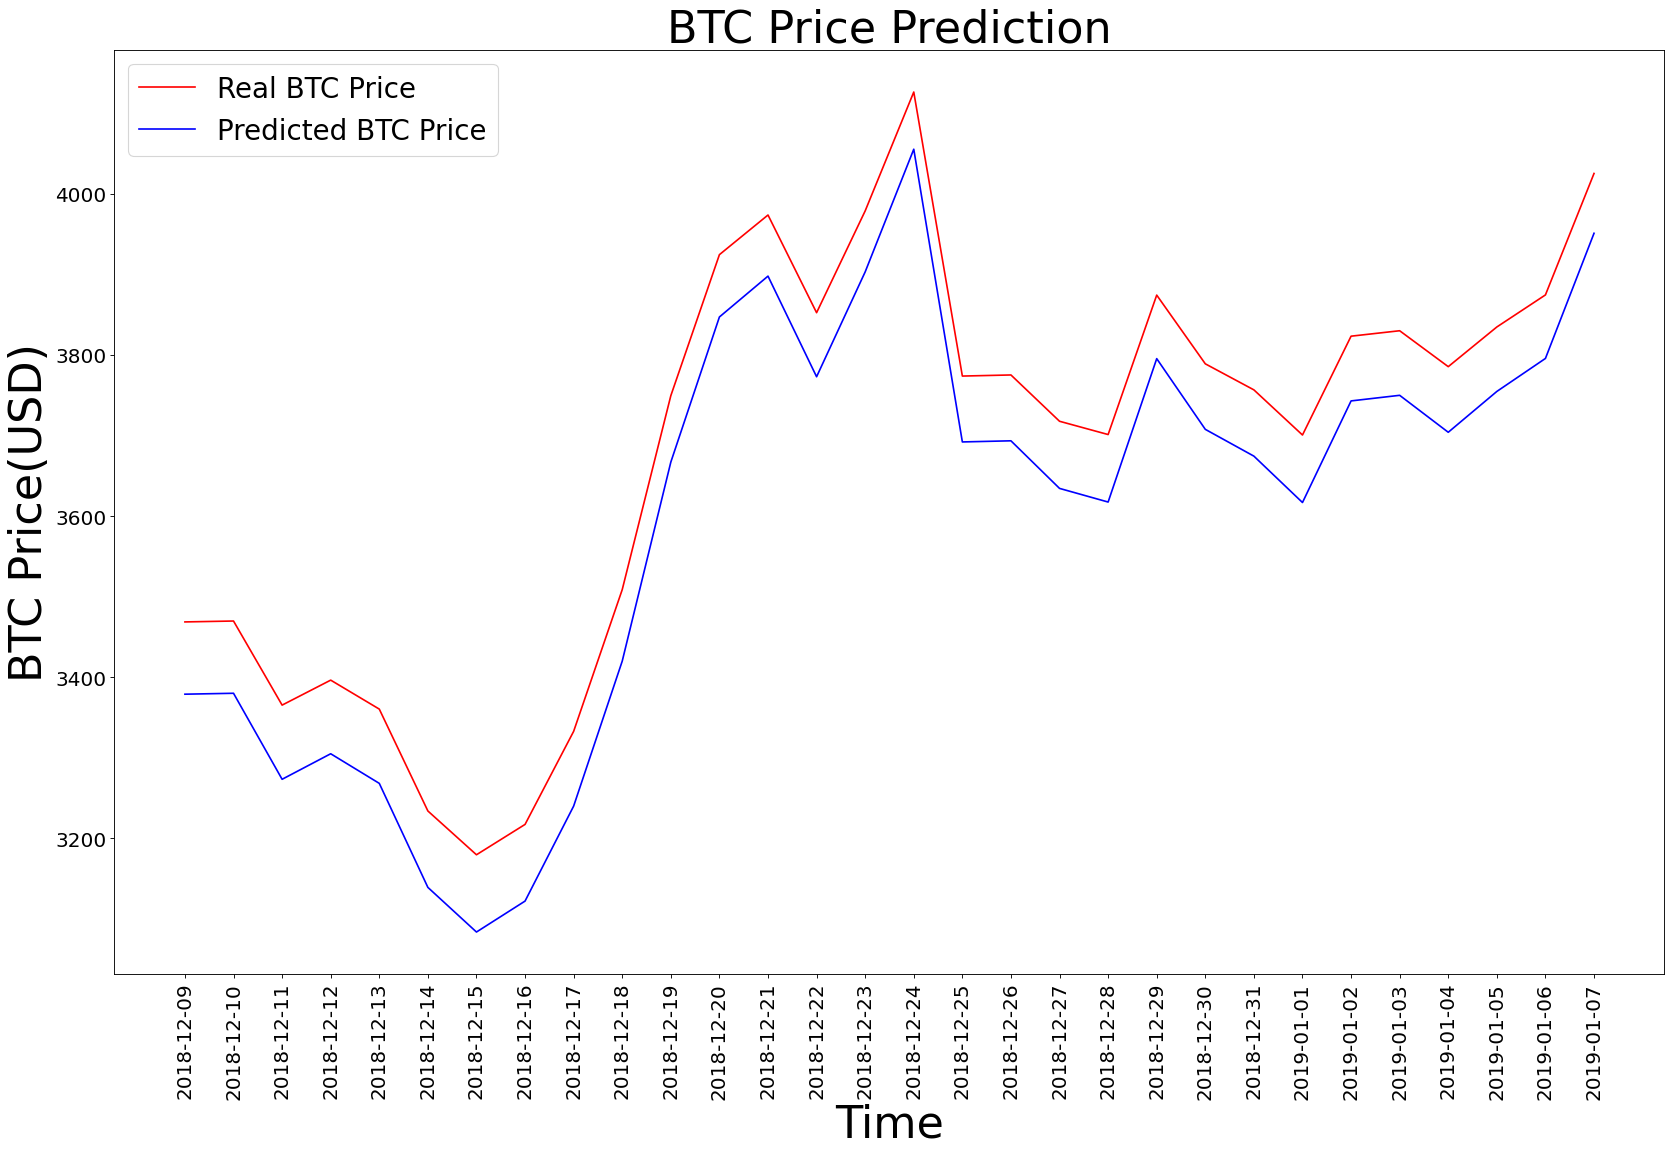

In [75]:

# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)

labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()